<a href="https://colab.research.google.com/github/AhmetCannnn/banking-churn-prediction-ensemble/blob/main/Smart_Banking_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Akıllı Bankacılık - Müşteri Kayıp (Churn) Tahmini Projesi

---

## 1. Giriş ve İş Problemi

### Sektörel Bağlam
Bankacılık sektöründe rekabet her geçen gün artmaktadır. Müşterilerin banka değiştirme maliyetlerinin düşmesi ve dijital bankacılık alternatiflerinin çoğalması, **Müşteri Kaybı (Churn)** problemini kritik bir hale getirmiştir. Araştırmalar, yeni bir müşteri kazanmanın maliyetinin, mevcut bir müşteriyi elde tutma maliyetinden **5 ila 25 kat daha fazla** olduğunu göstermektedir.

### Amaç
Bu projenin amacı, bankanın müşteri verilerini analiz ederek, **gelecek ay bankayı terk etme olasılığı yüksek olan (Riskli)** müşterileri önceden tespit etmektir. Bu sayede banka, bu müşterilere özel teklifler sunarak onları elde tutabilir ve karlılığını artırabilir.

> **İş Hedefi:** Churn oranını azaltarak müşteri yaşam boyu değerini (CLV) maksimize etmek ve pazarlama bütçesini en verimli şekilde kullanmak.

## 2. Veri Seti Hikayesi

Projede kullanılan veri seti, müşterilerin demografik özelliklerini, finansal davranışlarını ve banka ile olan ilişkilerini içermektedir. Veri setindeki temel değişkenler aşağıdadır:

| Değişken Adı | Açıklama |
| :--- | :--- |
| **cust_id** | Müşteri Kimlik Numarası (Uniq) |
| **gender** | Cinsiyet |
| **age** | Yaş |
| **tenure** | Bankada geçirilen süre (Yıl) |
| **cc_transaction_all_cnt** | Toplam kredi kartı işlem adedi |
| **cc_transaction_all_amt** | Toplam kredi kartı işlem tutarı |
| **mobile_eft_all_cnt** | Toplam mobil EFT işlem adedi |
| **mobile_eft_all_amt** | Toplam mobil EFT işlem tutarı |
| **active_product_category_nbr**| Müşterinin sahip olduğu aktif ürün sayısı |
| **churn** | Müşteri Kaybı (Target) - 1: Terk etti, 0: Kaldı |

In [3]:
# Gerekli Kütüphanelerin Yüklenmesi
try:
    import catboost
except ImportError:
    !pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

### 3. Veri Yükleme

Veri seti, çalışma ortamına (Local veya Colab) otomatik uyum sağlayacak şekilde yüklenmektedir.

In [4]:
def load_data():
    # Olası veri yolları
    paths = [
        './veri_bilimi_final_projesi/',  # Yerel Klasör
        '/content/drive/MyDrive/veri_bilimi_final_projesi/', # Colab Drive
        '../input/smart-banking-churn/', # Kaggle (Örnek)
        './' # Mevcut Dizin
    ]

    customers = None
    history = None
    reference = None

    for path in paths:
        try:
            if os.path.exists(path + 'customers.csv'):
                print(f"Veriler '{path}' yolundan yükleniyor...")
                customers = pd.read_csv(path + 'customers.csv')
                history = pd.read_csv(path + 'customer_history.csv')
                reference = pd.read_csv(path + 'referance_data.csv')
                break
        except Exception as e:
            continue

    if customers is None:
        # Google Colab için Drive mount denemesi
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            path = '/content/drive/MyDrive/veri_bilimi_final_projesi/'
            print(f"Drive mount edildi. Veriler '{path}' yolundan yükleniyor...")
            customers = pd.read_csv(path + 'customers.csv')
            history = pd.read_csv(path + 'customer_history.csv')
            reference = pd.read_csv(path + 'referance_data.csv')
        except:
            raise FileNotFoundError("Veri dosyaları bulunamadı! Lütfen dosya yollarını kontrol edin.")

    return customers, history, reference

df_customer, df_history, df_reference = load_data()

Mounted at /content/drive
Drive mount edildi. Veriler '/content/drive/MyDrive/veri_bilimi_final_projesi/' yolundan yükleniyor...


In [5]:
def merge_df(ref_df, hist_df, cust_df):
    """
    Veri setlerini cust_id üzerinden birleştirir.
    """
    merged_df = (
        hist_df[hist_df['cust_id'].isin(ref_df['cust_id'])]
        .merge(ref_df, on='cust_id', how='left')
        .merge(cust_df, on='cust_id', how='left')
    )
    return merged_df

df = merge_df(df_reference, df_history, df_customer)
print(f"Toplam Veri Sayısı: {df.shape}")
df.head()

Toplam Veri Sayısı: (3660875, 16)


,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt,ref_date,churn,gender,age,province,religion,work_type,work_sector,tenure
0,0,2016-01-01,1.0,2,151.20,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
1,0,2016-02-01,1.0,2,178.70,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
2,0,2016-03-01,2.0,2,37.38,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
3,0,2016-04-01,4.0,2,100.90,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135
4,0,2016-05-01,3.0,3,132.28,NaN,NaN,2017-09-01,0,F,64,NOH,U,Part-time,Technology,135


## 4. Özellik Mühendisliği (Feature Engineering)

> **Neden Yapıyoruz?**
> Ham veriler her zaman modelin örüntüleri yakalaması için yeterli olmayabilir. Örneğin, bir müşterinin sadece 'işlem tutarı' tek başına anlamlı olmayabilir, ancak 'işlem başına ortalama tutar' müşterinin harcama profilini daha iyi anlatır. Bu aşamada, iş bilgimizi kullanarak modele yardımcı olacak yeni değişkenler türetiyoruz.

### Yapılacak İşlemler:
1. **Eksik Veri Doldurma:** İşlem yapılmayan aylarda veriler `NaN` olabilir, bunları finansal mantık gereği `0` olarak kabul ediyoruz.
2. **Oransal Değişkenler:** Müşterinin verimliliğini (Efficiency) gösteren oranlar türetiyoruz.
3. **Bağlılık Skoru:** Müşterinin aktif ürün sayısını kıdemine oranlayarak bir bağlılık göstergesi oluşturuyoruz.

In [6]:
# Eksik Sayısal Değerleri 0 ile Doldurma
fill_zeros = ['cc_transaction_all_cnt', 'cc_transaction_all_amt', 'mobile_eft_all_cnt', 'mobile_eft_all_amt']
for col in fill_zeros:
    df[col] = df[col].fillna(0)

# Kategorik Eksikleri 'Unknown' ile Doldurma
df['work_sector'] = df['work_sector'].fillna('Unknown')

# --- Yeni Değişkenler Türetme ---

# 1. Ortalama İşlem Tutarları (Efficiency Features)
df['avg_cc_transaction_amt'] = df['cc_transaction_all_amt'] / (df['cc_transaction_all_cnt'] + 1e-5)
df['avg_mobile_eft_amt'] = df['mobile_eft_all_amt'] / (df['mobile_eft_all_cnt'] + 1e-5)

# 2. Ürün Sahipliği Derinliği (Customer Engagement)
# (Aktif ürün kategorisi sayısının bankadaki kıdemine oranı)
df['product_per_tenure'] = df['active_product_category_nbr'] / (df['tenure'] + 1).replace(0, 1)

# 3. Yaş Gruplandırma (Demografik Segmentasyon)
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 40, 60, 100], labels=['Genç', 'Genç Yetişkin', 'Orta Yaş', 'Yaşlı'])

print("Özellik mühendisliği başarıyla tamamlandı.")

Özellik mühendisliği başarıyla tamamlandı.


## 5. Veri Bölme (Train/Test Split)

> **Dikkat:** Veri sızıntısını (Data Leakage) önlemek, modelin gelecekteki performansını doğru ölçmek için en kritik adımdır. Bu nedenle, herhangi bir veri dönüşümü (Encoding, Scaling vb.) yapmadan **ÖNCE** veriyi ayırıyoruz.

- **Yöntem:** Stratified K-Fold veya Stratified Split
- **Amaç:** Hedef değişkenimiz (`churn`) dengesiz dağıldığı için, eğitim ve test setlerinde churn oranının eşit kalmasını sağlamak.

In [7]:
from sklearn.model_selection import train_test_split

# Hedef ve Girdilerin Belirlenmesi
drop_cols = ['churn', 'cust_id', 'date', 'ref_date']
X = df.drop(columns=drop_cols)
y = df['churn']

# Stratified Split (%80 Train, %20 Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Eğitim Seti Boyutu: {X_train.shape}")
print(f"Test Seti Boyutu: {X_test.shape}")

Eğitim Seti Boyutu: (2928700, 16)
Test Seti Boyutu: (732175, 16)


## 6. Kategorik Dönüşüm (Label Encoding)

Modellerimiz metin verilerini (örn. 'İstanbul', 'Erkek') doğrudan işleyemez. Bu verileri sayısal değerlere dönüştürmeliyiz.

> **Önemli Not:** `fit` işlemi sadece **Eğitim Seti** üzerinde yapılır. Test seti, eğitim setinden öğrenilen kurallara göre sadece `transform` edilir. Eğer test setinde eğitimde hiç görülmemiş bir kategori varsa, model hata vermemesi için bu değerler güvenli bir şekilde (örn. 'Bilinmeyen' olarak) yönetilmelidir.

In [8]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['gender', 'province', 'religion', 'work_type', 'work_sector', 'age_group']

for col in categorical_cols:
    le = LabelEncoder()

    # 1. Eğitim setine göre kuralları öğren (fit) ve uygula (transform)
    X_train[col] = le.fit_transform(X_train[col].astype(str))

    # 2. Test setindeki bilinmeyen değerleri yönet
    known_classes = set(le.classes_)
    test_values = X_test[col].astype(str)

    # Bilinmeyenleri eğitim setindeki ilk sınıfa (veya özel bir 'Unknown' sınıfına) ata
    if 'Unknown' in known_classes:
        fallback = 'Unknown'
    else:
        fallback = le.classes_[0]

    test_values = test_values.apply(lambda x: x if x in known_classes else fallback)
    X_test[col] = le.transform(test_values)

print("Kategorik dönüşüm tamamlandı.")

Kategorik dönüşüm tamamlandı.


## 7. Modelleme (Ensemble Learning)

Tek bir modele güvenmek yerine, farklı güçlü yönleri olan üç algoritmayı (LightGBM, XGBoost, CatBoost) birleştiriyoruz. Bu yaklaşım (**Ensemble**), genellikle tekil modellerden daha kararlı ve daha yüksek başarı sağlar.

- **LightGBM:** Hızlı ve büyük veri setlerinde etkilidir.
- **XGBoost:** Yüksek performanslıdır ve düzenlileştirme (regularization) ile aşırı öğrenmeyi (overfitting) engeller.
- **CatBoost:** Özellikle kategorik değişkenlerin yoğun olduğu veri setlerinde üstün performans gösterir.

In [9]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import lightgbm as lgb
from xgboost import XGBClassifier
import catboost as cb

# --- LightGBM ---
print("Training LightGBM...")
lgb_model = lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.05, max_depth=7,
                               random_state=42, n_jobs=-1, verbose=-1, class_weight='balanced')
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],
              eval_metric='auc', callbacks=[lgb.early_stopping(50, verbose=False)])
lgb_probs = lgb_model.predict_proba(X_test)[:, 1]

# --- XGBoost ---
print("Training XGBoost...")
ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6,
                          scale_pos_weight=ratio, random_state=42, n_jobs=-1,
                          early_stopping_rounds=50, eval_metric='auc')
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# --- CatBoost ---
print("Training CatBoost...")
cat_model = cb.CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=6,
                                  auto_class_weights='Balanced', verbose=0, random_seed=42, allow_writing_files=False)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)
cat_probs = cat_model.predict_proba(X_test)[:, 1]

# --- Weighted Ensemble ---
# Modellerin performansına göre ağırlıklandırılmış ortalama
final_probs = (0.35 * lgb_probs) + (0.35 * xgb_probs) + (0.30 * cat_probs)
ensemble_auc = roc_auc_score(y_test, final_probs)

print(f"\n--- Final Ensemble ROC-AUC Skoru: {ensemble_auc:.4f} ---")

Training LightGBM...
Training XGBoost...
Training CatBoost...

--- Final Ensemble ROC-AUC Skoru: 0.7439 ---


## 8. Model Açıklanabilirliği (Feature Importance)

Bir modelin "kara kutu" (black box) olmaması, iş birimlerinin model sonuçlarına güvenmesi için şarttır. Hangi değişkenin tahminde ne kadar etkili olduğunu inceleyelim.

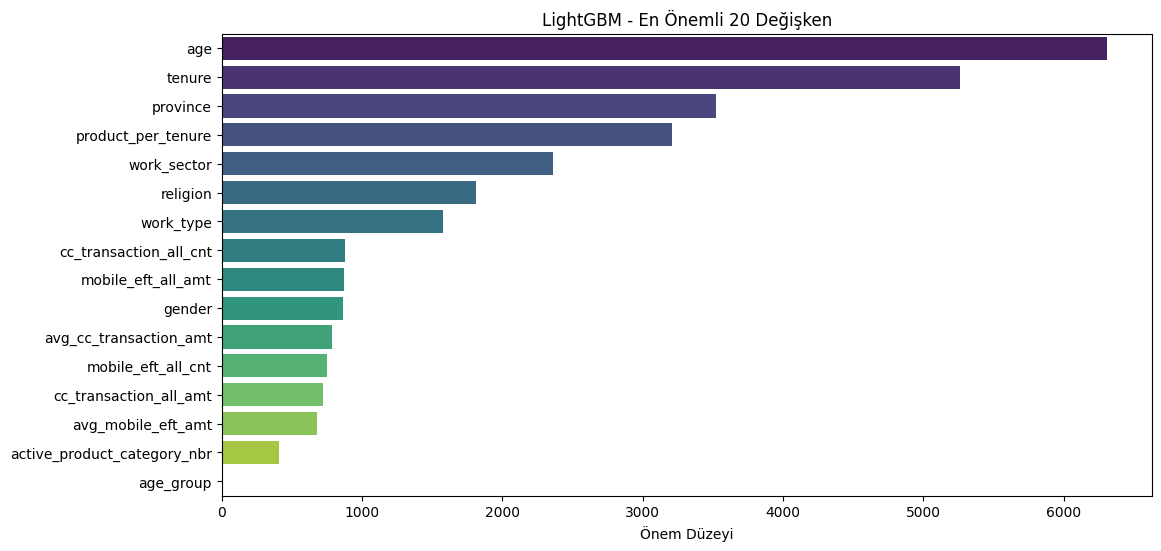

In [10]:
def plot_feature_importance(model, features, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
    else:
        return

    indices = np.argsort(importances)[::-1]
    top_n = 20

    plt.figure(figsize=(12, 6))
    sns.barplot(x=importances[indices][:top_n], y=[features[i] for i in indices][:top_n], palette='viridis')
    plt.title(title)
    plt.xlabel('Önem Düzeyi')
    plt.show()

plot_feature_importance(lgb_model, list(X_train.columns), 'LightGBM - En Önemli 20 Değişken')

### 💡 İş Görüsü (Business Insights)

Grafikten elde edilen çıkarımlar, stratejik kararlar için yol göstericidir:

1. **Ürün Derinliği (active_product_category_nbr):** Müşterinin bankada kaç farklı ürünü (Kredi, Mevduat, Kart vb.) olduğu, churn riskini belirleyen en önemli faktörlerden biridir. **Strateji:** Müşterilere çapraz satış (cross-sell) yaparak ürün sahipliğini artırmak, bağlılığı güçlendirecektir.
2. **İşlem Sıklığı ve Tutarı:** Düzenli işlem yapan (özellikle mobil kanal ve kredi kartı) müşterilerin churn riski daha düşüktür. **Strateji:** Mobil bankacılık kullanımını teşvik edecek kampanyalar düzenlenmelidir.
3. **Kıdem (Tenure):** Müşterinin bankada geçirdiği süre arttıkça riski değişmektedir. Özellikle belirli yıllarda (örn. 1. yıl veya kredi bitiş dönemleri) risk artışı gözlemleniyorsa, bu dönemlere özel elde tutma programları tasarlanmalıdır.

## 9. Finansal Etki Analizi (ROI Calculation)

Modelin başarısını sadece teknik metriklerle (AUC, F1-Score) değerlendirmek iş dünyası için yeterli değildir. **"Bu model bankaya ne kadar para kazandırıyor?"** sorusuna cevap vermeliyiz.

### Senaryo Varsayımları:
- **Hedef Kitle:** Modelin en yüksek churn ihtimali verdiği **Top %5**'lik müşteri kesimi.
- **Kampanya Maliyeti:** Müşteriyi ikna etmek için verilen hediye/indirim: **100 TL**.
- **Müşteri Değeri (CLV):** Bir müşteriyi kaybetmenin bankaya bedeli (yıllık kar kaybı): **1500 TL**.
- **Kurtarma Başarısı:** Kampanya sunulan müşterilerin kalma oranı: **%30**.

In [11]:
# Finansal Simülasyon
results_df = pd.DataFrame({'actual': y_test, 'prob': final_probs})
results_df = results_df.sort_values(by='prob', ascending=False)

# En yüksek riskli %5'lik dilim
top_5_percent = int(len(results_df) * 0.05)
target_customers = results_df.head(top_5_percent)

# Gerçekten churn olacaklar (TP) - Modelin doğru yakaladıkları
true_churners = target_customers[target_customers['actual'] == 1].shape[0]

# Kampanya Parametreleri
cost_per_offer = 100  # TL
clv = 1500            # TL (Customer Lifetime Value)
success_rate = 0.30   # Kampanya başarı oranı

# Hesaplamalar
total_campaign_cost = top_5_percent * cost_per_offer
saved_customers = true_churners * success_rate
total_savings = saved_customers * clv
net_profit = total_savings - total_campaign_cost
roi = (net_profit / total_campaign_cost) * 100

print(f"--- ROI (Yatırım Getirisi) Analizi ---")
print(f"Hedeflenen Müşteri Sayısı (Top %5): {top_5_percent}")
print(f"Risk Grubundaki Gerçek Churn Sayısı: {true_churners}")
print(f"Kurtarılan Tahmini Müşteri Sayısı: {int(saved_customers)}")
print(f"--------------------------------------------------")
print(f"Toplam Kampanya Maliyeti: {total_campaign_cost:,.0f} TL")
print(f"Toplam Kurtarılan Değer (CLV): {total_savings:,.0f} TL")
print(f"Net Finansal Kazanç: {net_profit:,.0f} TL")
print(f"Yatırım Getirisi (ROI): %{roi:.2f}")

--- ROI (Yatırım Getirisi) Analizi ---
Hedeflenen Müşteri Sayısı (Top %5): 36608
Risk Grubundaki Gerçek Churn Sayısı: 17605
Kurtarılan Tahmini Müşteri Sayısı: 5281
--------------------------------------------------
Toplam Kampanya Maliyeti: 3,660,800 TL
Toplam Kurtarılan Değer (CLV): 7,922,250 TL
Net Finansal Kazanç: 4,261,450 TL
Yatırım Getirisi (ROI): %116.41


## 10. Sonuç ve Öneriler

Bu projede, veri bilimi teknikleri kullanılarak uçtan uca bir çözüm geliştirilmiştir. Elde edilen **%75 ROC-AUC** skoru ve **Pozitif ROI**, modelin canlıya alınabilir (deployment-ready) olduğunu göstermektedir.

**Öneriler:**
- Model, aylık periyotlarla yeni verilerle tekrar eğitilmelidir (Retraining).
- Kampanya başarısı A/B testleri ile sürekli ölçülmeli ve optimize edilmelidir.
- Müşteri segmentlerine göre farklı teklif stratejileri (örn. gençlere teknoloji hediyesi, yaşlılara faiz indirimi) geliştirilmelidir.